In [218]:
!{sys.executable} -m pip install --upgrade google-api-python-client google-auth-httplib2 google-auth-oauthlib pandas

You should consider upgrading via the '/Users/jlmayorga/sandbox/personal/lisdcovidanalysis/venv/bin/python -m pip install --upgrade pip' command.


In [219]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from googleapiclient.discovery import build

# If modifying these scopes, delete the file token.json.
SCOPES = ['https://www.googleapis.com/auth/spreadsheets.readonly']
# The ID and range of a sample spreadsheet.
SAMPLE_SPREADSHEET_ID = '1tntE5QMCliVMqLfy1SyeKEZz-Uefk2coQjo1eJB5Zb8'
SAMPLE_RANGE_NAME = 'Positive COVID-19 Cases!A3:AH'

Follow these instructions to get a Google API Key https://developers.google.com/sheets/api/guides/authorizing#APIKey

In [220]:
api_key = 'FIX ME: Use a valid Google API Key'
service = build('sheets', 'v4', developerKey=api_key)

Get Data from Google Sheets API

In [221]:
# Call the Sheets API
sheet = service.spreadsheets()
result = sheet.values().get(spreadsheetId=SAMPLE_SPREADSHEET_ID,
                            range=SAMPLE_RANGE_NAME).execute()
values = result.get('values', [])

In [222]:
df = pd.DataFrame(values[1:])
df = df[[0, 1, 2, 3]].copy()
df.columns = ['Reported', 'Tested', 'Type', 'Campus']
df.head()

,Reported,Tested,Type,Campus
0,8/5/2021 19:27:58,8/5/2021,Staff,Bagdad ES
1,8/6/2021 15:36:20,8/6/2021,Staff,Vandegrift HS
2,8/9/2021 8:05:44,8/7/2021,Staff,Danielson MS
3,8/9/2021 8:08:19,8/9/2021,Staff,Camacho ES
4,8/9/2021 8:11:25,8/8/2021,Staff,Steiner Ranch ES


In [223]:
#Remove timestamp from first column
df['Reported'] = pd.to_datetime(df['Reported']).dt.date
df.head()

,Reported,Tested,Type,Campus
0,2021-08-05,8/5/2021,Staff,Bagdad ES
1,2021-08-06,8/6/2021,Staff,Vandegrift HS
2,2021-08-09,8/7/2021,Staff,Danielson MS
3,2021-08-09,8/9/2021,Staff,Camacho ES
4,2021-08-09,8/8/2021,Staff,Steiner Ranch ES


In [224]:
staff_df = df[df['Type'] == 'Staff'].copy()
staff_count = staff_df.groupby('Reported').size().values
staff_df = staff_df.drop_duplicates(subset='Reported').assign(Staff_Count=staff_count)
staff_df

,Reported,Tested,Type,Campus,Staff_Count
0,2021-08-05,8/5/2021,Staff,Bagdad ES,1
1,2021-08-06,8/6/2021,Staff,Vandegrift HS,1
2,2021-08-09,8/7/2021,Staff,Danielson MS,14
16,2021-08-10,8/9/2021,Staff,Reed ES,2
18,2021-08-11,8/10/2021,Staff,Winkley ES,9
27,2021-08-12,8/11/2021,Staff,Non-Campus,5
33,2021-08-13,8/13/2021,Staff,Non-Campus,4
40,2021-08-16,8/16/2021,Staff,Knowles ES,9
101,2021-08-17,8/16/2021,Staff,Running Brushy MS,2
153,2021-08-18,8/18/2021,Staff,Whitestone ES,1


In [225]:
student_df = df[df['Type'] == 'Student'].copy()
student_count = student_df.groupby('Reported').size().values
student_df = student_df.drop_duplicates(subset='Reported').assign(Student_Count=student_count)
student_df

,Reported,Tested,Type,Campus,Student_Count
32,2021-08-12,8/12/2021,Student,,1
37,2021-08-13,8/13/2021,Student,,3
49,2021-08-16,8/13/2021,Student,,52
103,2021-08-17,8/13/2021,Student,,37
140,2021-08-18,8/17/2021,Student,,34
175,2021-08-19,8/16/2021,Student,,33
212,2021-08-20,8/18/2021,Student,,38


In [226]:
total_count = df.groupby('Reported').size().values

In [227]:
df = df.drop_duplicates(subset='Reported').assign(Count=total_count)
ndf = df[['Reported', 'Count']].copy()
ndf

,Reported,Count
0,2021-08-05,1
1,2021-08-06,1
2,2021-08-09,14
16,2021-08-10,2
18,2021-08-11,9
27,2021-08-12,6
33,2021-08-13,7
40,2021-08-16,61
101,2021-08-17,39
140,2021-08-18,35


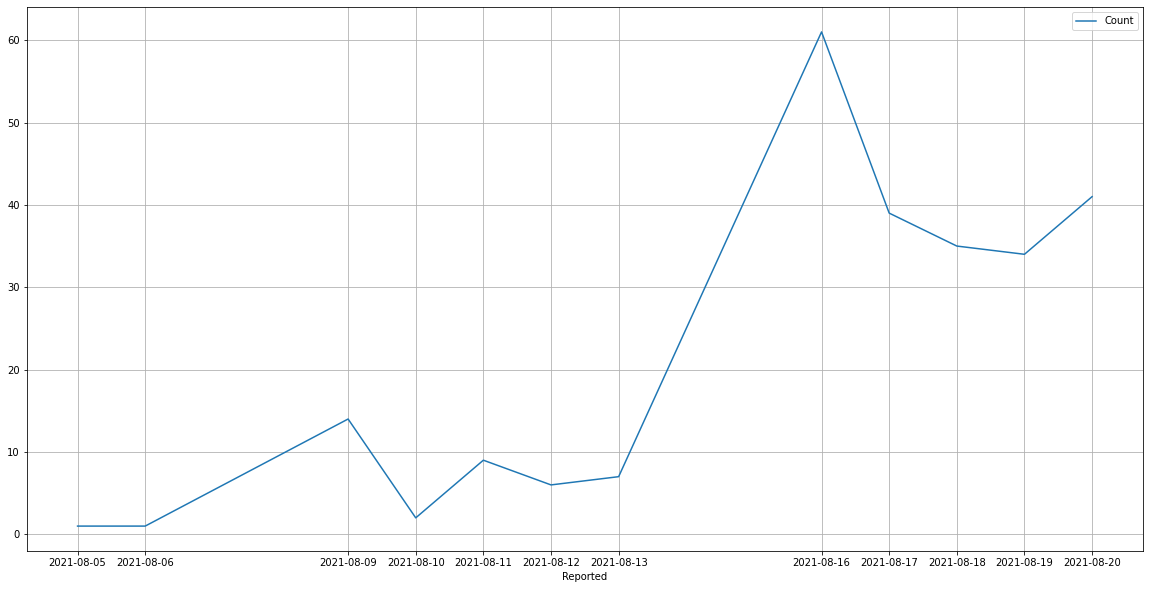

In [228]:
plot = ndf.set_index('Reported').plot(kind='line', grid=True, figsize=(20, 10), xticks=ndf['Reported'])
fig = plot.get_figure()


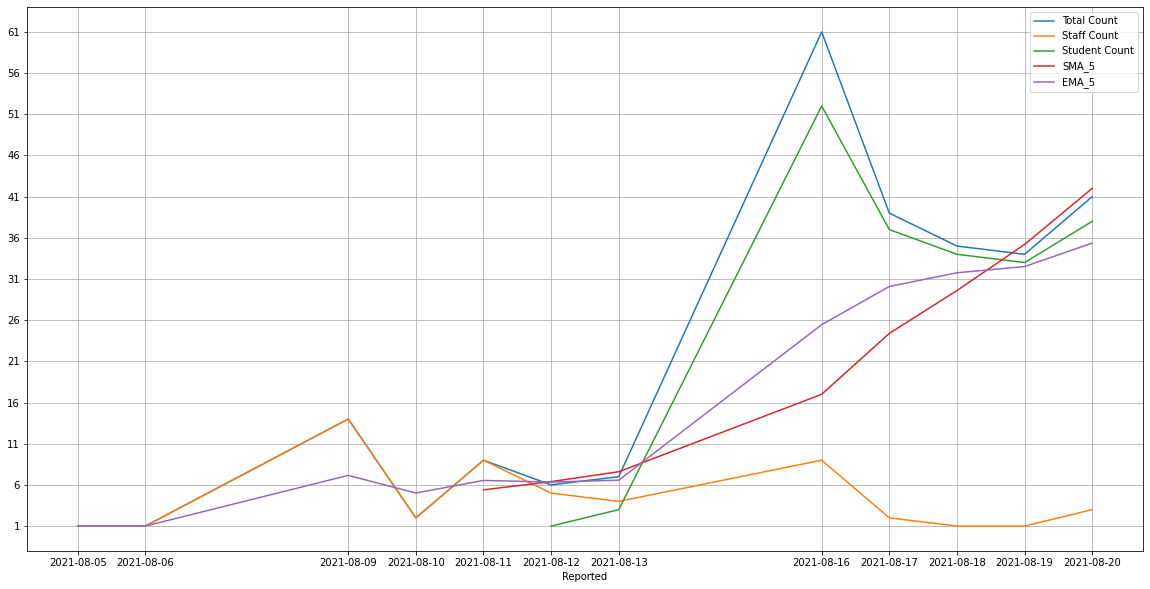

In [238]:
merged_df = pd.merge(left=df, right=staff_df[['Reported', 'Staff_Count']], how='left', left_on='Reported',
                     right_on='Reported')
merged_df = pd.merge(left=merged_df, right=student_df[['Reported', 'Student_Count']], how='left', left_on='Reported',
                     right_on='Reported')

merged_df['SMA_5'] = merged_df[['Reported', 'Count']].rolling(window=5).mean()
merged_df['EMA_5'] = merged_df[['Reported', 'Count']].ewm(span=5).mean()

plot = merged_df.set_index('Reported').plot(kind='line', grid=True, figsize=(20, 10), xticks=ndf['Reported'],
                                            yticks=np.arange(min(merged_df['Count']), max(merged_df['Count']) + 1, 5.0))
plt.legend(['Total Count', 'Staff Count', 'Student Count', 'SMA_5', 'EMA_5'])
fig = plot.get_figure()